In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Xarray with I/O dependencies
!pip install xarray[io]

# Or install with all features
!pip install xarray[complete]


In [ ]:
!pip install netCDF4
!pip install h5netcdf  # Alternative NetCDF backend

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load your Xarray dataset
# Replace with your actual file path in Google Drive
ds = xr.open_dataset('/content/drive/MyDrive/datasets/screening_task.nc') # <--- REPLACE WITH YOUR FILE PATH

# Define central girder elements
central_girder_elements = [15, 24, 33, 42, 51, 60, 69, 78, 83]

In [ ]:
# Explore the dataset structure
print("\n Dataset Structure:")
print(ds)
print("\n Dataset Dimensions:", ds.dims)
print("\n Dataset Coordinates:", ds.coords)
print("\n Dataset Variables:", list(ds.data_vars))


 Dataset Structure:
<xarray.Dataset> Size: 21kB
Dimensions:    (Element: 85, Component: 30)
Coordinates:
  * Element    (Element) int32 340B 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85
  * Component  (Component) object 240B 'Mx_i' 'Mx_j' 'My_i' ... 'x' 'y' 'z'
    Loadcase   object 8B ...
Data variables:
    forces     (Element, Component) float64 20kB ...

 Dataset Dimensions: FrozenMappingWarningOnValuesAccess({'Element': 85, 'Component': 30})

 Dataset Coordinates: Coordinates:
  * Element    (Element) int32 340B 1 2 3 4 5 6 7 8 ... 78 79 80 81 82 83 84 85
  * Component  (Component) object 240B 'Mx_i' 'Mx_j' 'My_i' ... 'x' 'y' 'z'
    Loadcase   object 8B ...

 Dataset Variables: ['forces']


In [ ]:
print(f"\nCentral girder elements: {central_girder_elements}")



Central girder elements: [15, 24, 33, 42, 51, 60, 69, 78, 83]


In [ ]:
def extract_force_data(dataset, element_ids):
    """
    Extract Mz (bending moment) and Vy (shear force) data for given elements

    Parameters:
    -----------
    dataset : xarray.Dataset
        The loaded Xarray dataset containing force data
    element_ids : list
        List of element IDs to extract data for

    Returns:
    --------
    dict : Dictionary containing extracted force data
    """

    # Initialize storage for extracted data
    bending_moments_i = []
    bending_moments_j = []
    shear_forces_i = []
    shear_forces_j = []

    # Extract data for each element
    for elem_id in element_ids:
        try:
            # Select data for current element
            # Adjust the dimension name based on your dataset structure
            # Common names: 'element', 'member', 'Element', 'Member'
            # Correctly access 'forces' DataArray and then select by 'Component'
            elem_data = dataset.sel(Element=elem_id) # Fixed 'element' to 'Element'

            # Extract values from the 'forces' DataArray
            bending_moments_i.append(float(elem_data['forces'].sel(Component='Mz_i').values))
            bending_moments_j.append(float(elem_data['forces'].sel(Component='Mz_j').values))
            shear_forces_i.append(float(elem_data['forces'].sel(Component='Vy_i').values))
            shear_forces_j.append(float(elem_data['forces'].sel(Component='Vy_j').values))

            print(f"Element {elem_id}: Mz_i={elem_data['forces'].sel(Component='Mz_i').values:.2f}, "
                  f"Mz_j={elem_data['forces'].sel(Component='Mz_j').values:.2f}, "
                  f"Vy_i={elem_data['forces'].sel(Component='Vy_i').values:.2f}, "
                  f"Vy_j={elem_data['forces'].sel(Component='Vy_j').values:.2f}")

        except Exception as e:
            print(f"Error extracting data for element {elem_id}: {e}")
            # Handle missing elements by using zeros or interpolation
            bending_moments_i.append(0.0)
            bending_moments_j.append(0.0)
            shear_forces_i.append(0.0)
            shear_forces_j.append(0.0)

    return {
        'Mz_i': np.array(bending_moments_i),
        'Mz_j': np.array(bending_moments_j),
        'Vy_i': np.array(shear_forces_i),
        'Vy_j': np.array(shear_forces_j),
        'element_ids': element_ids
    }

# Extract the data
print("\nExtracting force data for central girder...")
force_data = extract_force_data(ds, central_girder_elements)


Extracting force data for central girder...
Element 15: Mz_i=0.00, Mz_j=-6.33, Vy_i=-2.28, Vy_j=2.28
Element 24: Mz_i=6.33, Mz_j=-13.10, Vy_i=-2.44, Vy_j=2.44
Element 33: Mz_i=13.10, Mz_j=-20.43, Vy_i=-2.64, Vy_j=2.64
Element 42: Mz_i=20.43, Mz_j=-22.99, Vy_i=-0.92, Vy_j=0.92
Element 51: Mz_i=22.99, Mz_j=-17.48, Vy_i=1.99, Vy_j=-1.99
Element 60: Mz_i=17.48, Mz_j=-13.15, Vy_i=1.56, Vy_j=-1.56
Element 69: Mz_i=13.15, Mz_j=-8.88, Vy_i=1.53, Vy_j=-1.53
Element 78: Mz_i=8.88, Mz_j=-4.31, Vy_i=1.65, Vy_j=-1.65
Element 83: Mz_i=4.31, Mz_j=-0.00, Vy_i=1.55, Vy_j=-1.55


In [ ]:
# ============================================================
# Step 5: Create Continuous Position and Value Arrays
# ============================================================

def create_continuous_diagram_data(force_dict):
    """
    Create continuous position and value arrays for plotting

    Parameters:
    -----------
    force_dict : dict
        Dictionary containing force data from extract_force_data()

    Returns:
    --------
    dict : Dictionary with continuous positions and values for BMD and SFD
    """

    num_elements = len(force_dict['element_ids'])

    # For Bending Moment Diagram
    bmd_positions = []
    bmd_values = []

    for i in range(num_elements):
        # Start of element
        bmd_positions.append(i)
        bmd_values.append(force_dict['Mz_i'][i])

        # End of element
        bmd_positions.append(i + 1)
        bmd_values.append(force_dict['Mz_j'][i])

    # For Shear Force Diagram
    sfd_positions = []
    sfd_values = []

    for i in range(num_elements):
        # Start of element
        sfd_positions.append(i)
        sfd_values.append(force_dict['Vy_i'][i])

        # End of element
        sfd_positions.append(i + 1)
        sfd_values.append(force_dict['Vy_j'][i])

    return {
        'bmd_pos': np.array(bmd_positions),
        'bmd_val': np.array(bmd_values),
        'sfd_pos': np.array(sfd_positions),
        'sfd_val': np.array(sfd_values)
    }

# Create continuous data
diagram_data = create_continuous_diagram_data(force_data)

print(f"\nBMD positions: {diagram_data['bmd_pos']}")
print(f"BMD values: {diagram_data['bmd_val']}")
print(f"\nSFD positions: {diagram_data['sfd_pos']}")
print(f"SFD values: {diagram_data['sfd_val']}")


BMD positions: [0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9]
BMD values: [ 1.19015908e-13 -6.32640981e+00  6.32640981e+00 -1.31032630e+01
  1.31032630e+01 -2.04343629e+01  2.04343629e+01 -2.29894836e+01
  2.29894836e+01 -1.74753082e+01  1.74753082e+01 -1.31456063e+01
  1.31456063e+01 -8.88292425e+00  8.88292425e+00 -4.30808493e+00
  4.30808493e+00 -1.31450406e-13]

SFD positions: [0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9]
SFD values: [-2.27748931  2.27748931 -2.43964763  2.43964763 -2.63926988  2.63926988
 -0.9198361   0.9198361   1.9850873  -1.9850873   1.5586802  -1.5586802
  1.5346085  -1.5346085   1.64692898 -1.64692898  1.55089817 -1.55089817]


In [ ]:
# ============================================================
# Step 7: Optional - Load and Verify Element Connectivity
# ============================================================

# Load element connectivity data (if needed for verification)
connectivity_file = '/content/drive/My Drive/element_connectivity.csv'

try:
    connectivity_df = pd.read_csv(connectivity_file)
    print("\nElement Connectivity Data:")
    print(connectivity_df.head(10))

    # Verify continuity of central girder
    print("\nVerifying central girder continuity...")
    for i in range(len(central_girder_elements) - 1):
        current_elem = central_girder_elements[i]
        next_elem = central_girder_elements[i + 1]

        current_row = connectivity_df[connectivity_df['element_id'] == current_elem]
        next_row = connectivity_df[connectivity_df['element_id'] == next_elem]

        if not current_row.empty and not next_row.empty:
            j_node_current = current_row['j_node'].values[0]
            i_node_next = next_row['i_node'].values[0]

            if j_node_current == i_node_next:
                print(f"✓ Elements {current_elem} and {next_elem} are continuous")
            else:
                print(f"✗ Warning: Elements {current_elem} and {next_elem} may not be continuous")

except FileNotFoundError:
    print("\nConnectivity file not found. Skipping verification.")



Connectivity file not found. Skipping verification.


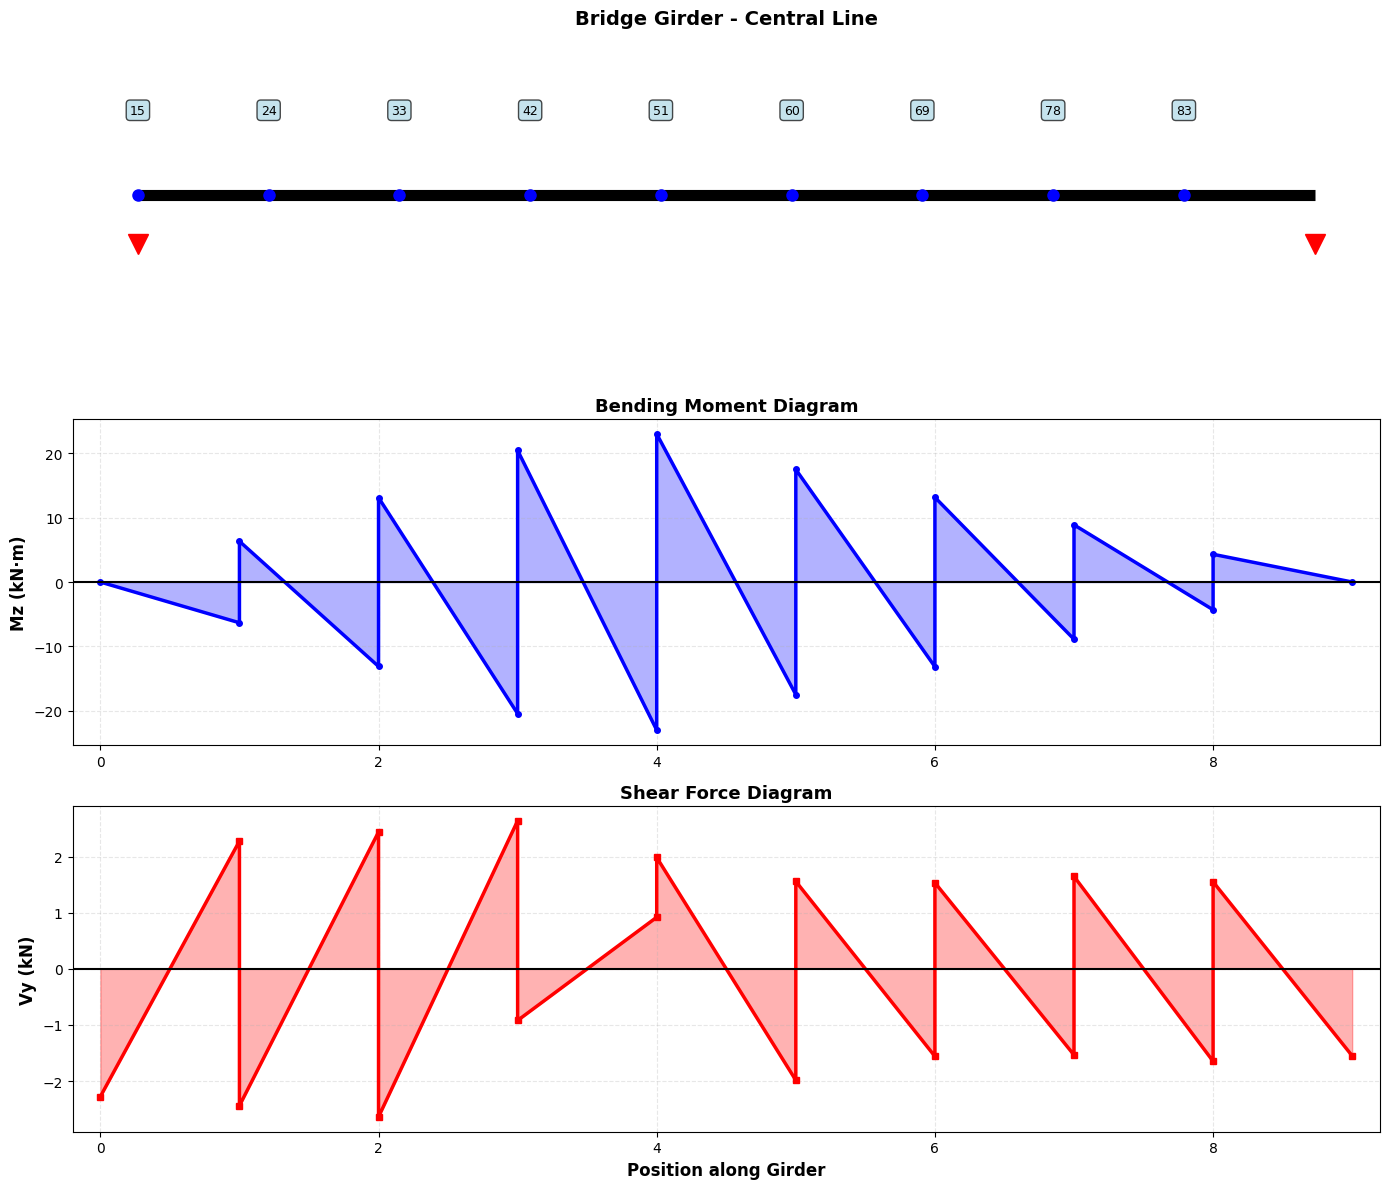

In [ ]:
def plot_sfd_bmd_traditional(diagram_data, element_ids):
    """
    Create traditional engineering-style SFD and BMD with values above/below baseline
    """

    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    # ========== BEAM REPRESENTATION ==========
    ax0 = axes[0]
    beam_length = len(element_ids)

    # Draw beam
    ax0.plot([0, beam_length], [0, 0], 'k-', linewidth=8, solid_capstyle='butt')

    # Draw supports
    for i in [0, beam_length]:
        ax0.plot(i, -0.3, 'v', markersize=15, color='red')

    # Mark elements
    for i, elem in enumerate(element_ids):
        ax0.plot(i, 0, 'o', markersize=8, color='blue', zorder=5)
        ax0.text(i, 0.5, f'{elem}', ha='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

    ax0.set_xlim(-0.5, beam_length + 0.5)
    ax0.set_ylim(-1, 1)
    ax0.set_title('Bridge Girder - Central Line', fontsize=14, fontweight='bold')
    ax0.axis('off')

    # ========== BENDING MOMENT DIAGRAM ==========
    ax1 = axes[1]
    ax1.plot(diagram_data['bmd_pos'], diagram_data['bmd_val'],
             'b-', linewidth=2.5, marker='o', markersize=4)
    ax1.fill_between(diagram_data['bmd_pos'], 0, diagram_data['bmd_val'],
                     alpha=0.3, color='blue')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylabel('Mz (kN·m)', fontsize=12, fontweight='bold')
    ax1.set_title('Bending Moment Diagram', fontsize=13, fontweight='bold')
    ax1.set_xlim(-0.2, beam_length + 0.2)

    # ========== SHEAR FORCE DIAGRAM ==========
    ax2 = axes[2]
    ax2.plot(diagram_data['sfd_pos'], diagram_data['sfd_val'],
             'r-', linewidth=2.5, marker='s', markersize=4)
    ax2.fill_between(diagram_data['sfd_pos'], 0, diagram_data['sfd_val'],
                     alpha=0.3, color='red')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlabel('Position along Girder', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Vy (kN)', fontsize=12, fontweight='bold')
    ax2.set_title('Shear Force Diagram', fontsize=13, fontweight='bold')
    ax2.set_xlim(-0.2, beam_length + 0.2)

    plt.tight_layout()
    plt.savefig('sfd_bmd_traditional.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create traditional plot
plot_sfd_bmd_traditional(diagram_data, central_girder_elements)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


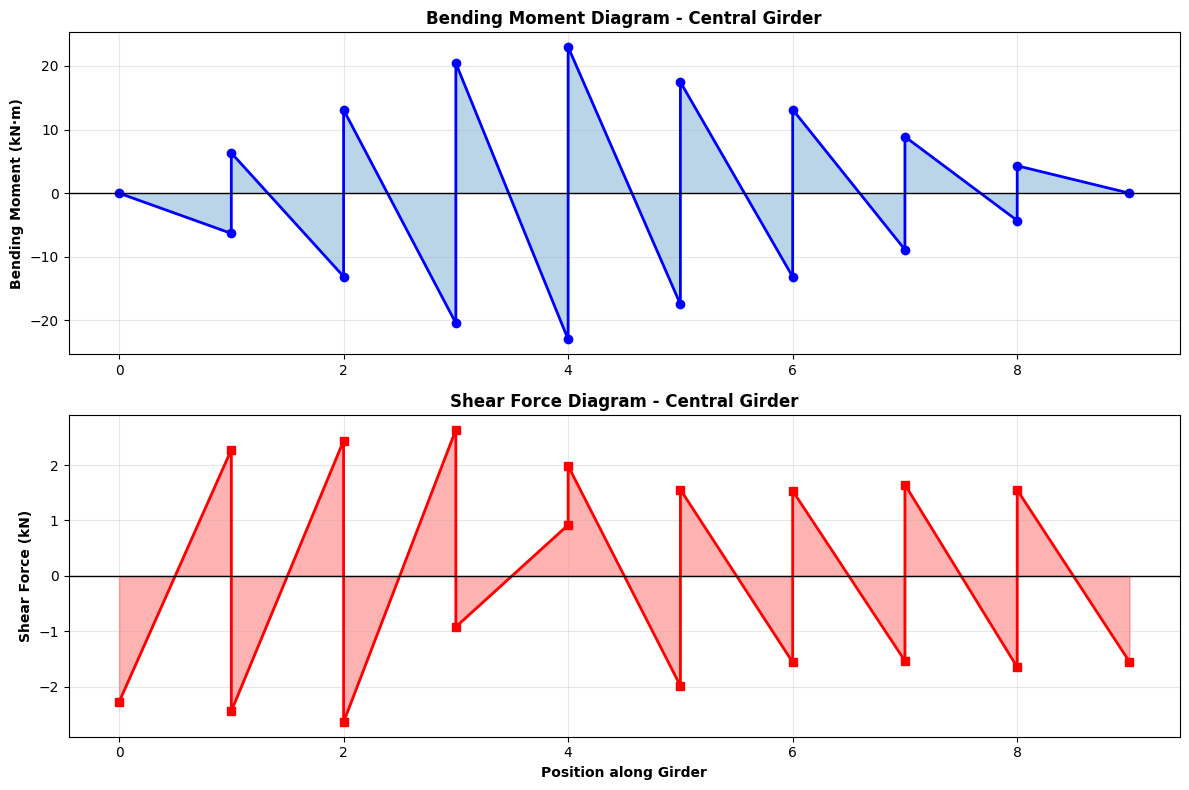

✓ Done!


In [ ]:
# ============================================================
# SIMPLE IMPLEMENTATION - Task 1: SFD and BMD
# ============================================================

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Mount Drive (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 1. LOAD DATA
# ============================================================

# Load Xarray dataset
# ds = xr.open_dataset('/content/drive/My Drive/Xarray_data.nc')

# Central girder elements
elements = [15, 24, 33, 42, 51, 60, 69, 78, 83]

# ============================================================
# 2. EXTRACT DATA
# ============================================================

# Initialize lists
Mz_i, Mz_j = [], []
Vy_i, Vy_j = [], []

# Extract for each element
for elem in elements:
    data = ds.sel(Element=elem) # Fixed 'element' to 'Element'
    # These variables (Mz_i, Mz_j, Vy_i, Vy_j) are components within 'forces'
    # Access them using .sel(Component='...')
    Mz_i.append(float(data['forces'].sel(Component='Mz_i').values))
    Mz_j.append(float(data['forces'].sel(Component='Mz_j').values))
    Vy_i.append(float(data['forces'].sel(Component='Vy_i').values))
    Vy_j.append(float(data['forces'].sel(Component='Vy_j').values))

# ============================================================
# 3. CREATE CONTINUOUS ARRAYS
# ============================================================

# Positions and values for plotting
bmd_x, bmd_y = [], []
sfd_x, sfd_y = [], []

for i in range(len(elements)):
    # BMD
    bmd_x.extend([i, i+1])
    bmd_y.extend([Mz_i[i], Mz_j[i]])

    # SFD
    sfd_x.extend([i, i+1])
    sfd_y.extend([Vy_i[i], Vy_j[i]])

# ============================================================
# 4. PLOT
# ============================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Bending Moment Diagram
ax1.plot(bmd_x, bmd_y, 'b-', linewidth=2, marker='o')
ax1.fill_between(bmd_x, 0, bmd_y, alpha=0.3)
ax1.axhline(0, color='black', linewidth=1)
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Bending Moment (kN·m)', fontweight='bold')
ax1.set_title('Bending Moment Diagram - Central Girder', fontweight='bold')

# Shear Force Diagram
ax2.plot(sfd_x, sfd_y, 'r-', linewidth=2, marker='s')
ax2.fill_between(sfd_x, 0, sfd_y, alpha=0.3, color='red')
ax2.axhline(0, color='black', linewidth=1)
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('Position along Girder', fontweight='bold')
ax2.set_ylabel('Shear Force (kN)', fontweight='bold')
ax2.set_title('Shear Force Diagram - Central Girder', fontweight='bold')

plt.tight_layout()
plt.savefig('sfd_bmd.png', dpi=300)
plt.show()

print("✓ Done!")